In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging


logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis import Analysis, AnalysisManager, GR_Confirmation, SpotDetection_Confirmation, SpotDetection_Confirmation_ER

c:\Users\formanj\GitHub\AngelFISH


Loads in the data from specified location

In [2]:
loc = None # r"Y:\smFISH_images\Eric_smFISH_images\20230511\GR_ICC_3hr_R1_1nM_0min_050823\GR_ICC_3hr_R1_1nM_0min_050823.h5"
log_location = r'\\munsky-nas.engr.colostate.edu\share\Users\Eric\AngelFISH_data'  # r'/Volumes/share/Users/Eric/All_Analysis'
am = AnalysisManager(location=loc, log_location=log_location, mac=False) # change this to your mounted drive location for this folder
# This analysis is best done with the NAS mounted 

In [3]:
# list all analysis done 
am.list_analysis_names()

Analysis_demo_2025-01-22
Analysis_DUSP1_D_Jan2125_2025-01-22
Analysis_DUSP1_E_Jan2125_2025-01-22
Analysis_DUSP1_M_Jan2125_2025-01-21
Analysis_demo_2025-01-21


['Analysis_demo_2025-01-22',
 'Analysis_DUSP1_D_Jan2125_2025-01-22',
 'Analysis_DUSP1_E_Jan2125_2025-01-22',
 'Analysis_DUSP1_M_Jan2125_2025-01-21',
 'Analysis_demo_2025-01-21']

In [4]:
# can filter on name and dates
am.select_analysis('DUSP1_M_Jan2125')


In [31]:
print(am.analysis_names)
am.location

['Analysis_DUSP1_M_Jan2125_2025-01-21', 'Analysis_DUSP1_M_Jan2125_2025-01-21', 'Analysis_DUSP1_M_Jan2125_2025-01-21']


['\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220725\\DUSP1_Dex_100nM_6hr_0min_072022\\DUSP1_Dex_100nM_6hr_0min_072022.h5',
 '\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220725\\DUSP1_Dex_100nM_6hr_150min_072022\\DUSP1_Dex_100nM_6hr_150min_072022.h5',
 '\\\\munsky-nas.engr.colostate.edu\\share\\smFISH_images\\Eric_smFISH_images\\20220725\\DUSP1_Dex_100nM_6hr_180min_072022\\DUSP1_Dex_100nM_6hr_180min_072022.h5']

In [6]:
am.list_datasets()

{'bigfish_min_threshold', 'bigfish_25_quartile', 'individual_spotdetection_thresholds', 'bigfish_max_threshold', 'bigfish_std_threshold', 'clusterresults', 'bigfish_90_quartile', 'position_indexs', 'spotresults', 'bigfish_75_quartile', 'bigfish_mean_threshold', 'cell_properties', 'cellresults', 'bigfish_median_threshold'}


Does analysis/confirmation

In [7]:
# select DUSP1 spot detection
# SD = SpotDetection_Confirmation(am)
SD = SpotDetection_Confirmation_ER(am)

In [8]:
# this loads the data into memory 
SD.get_data()

[INFO] Weighted threshold in [2,5): bottom 20% => 2.95


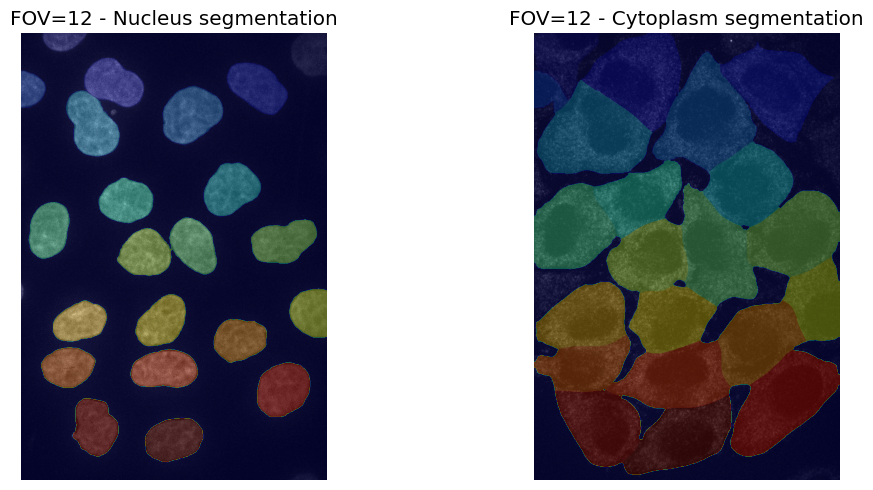

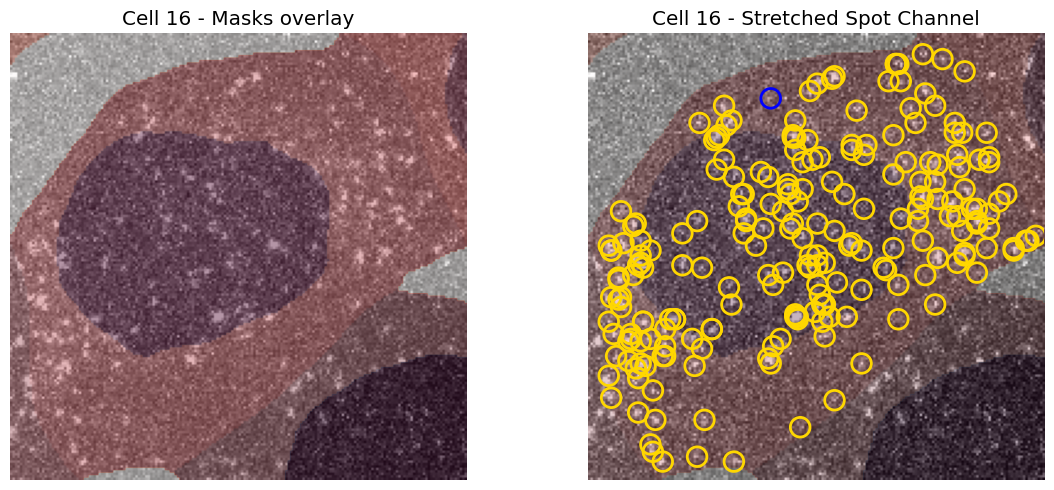

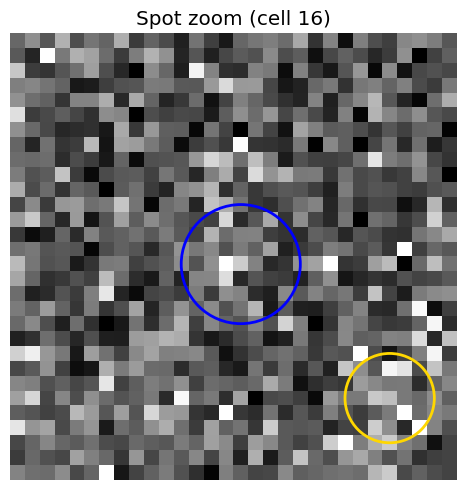

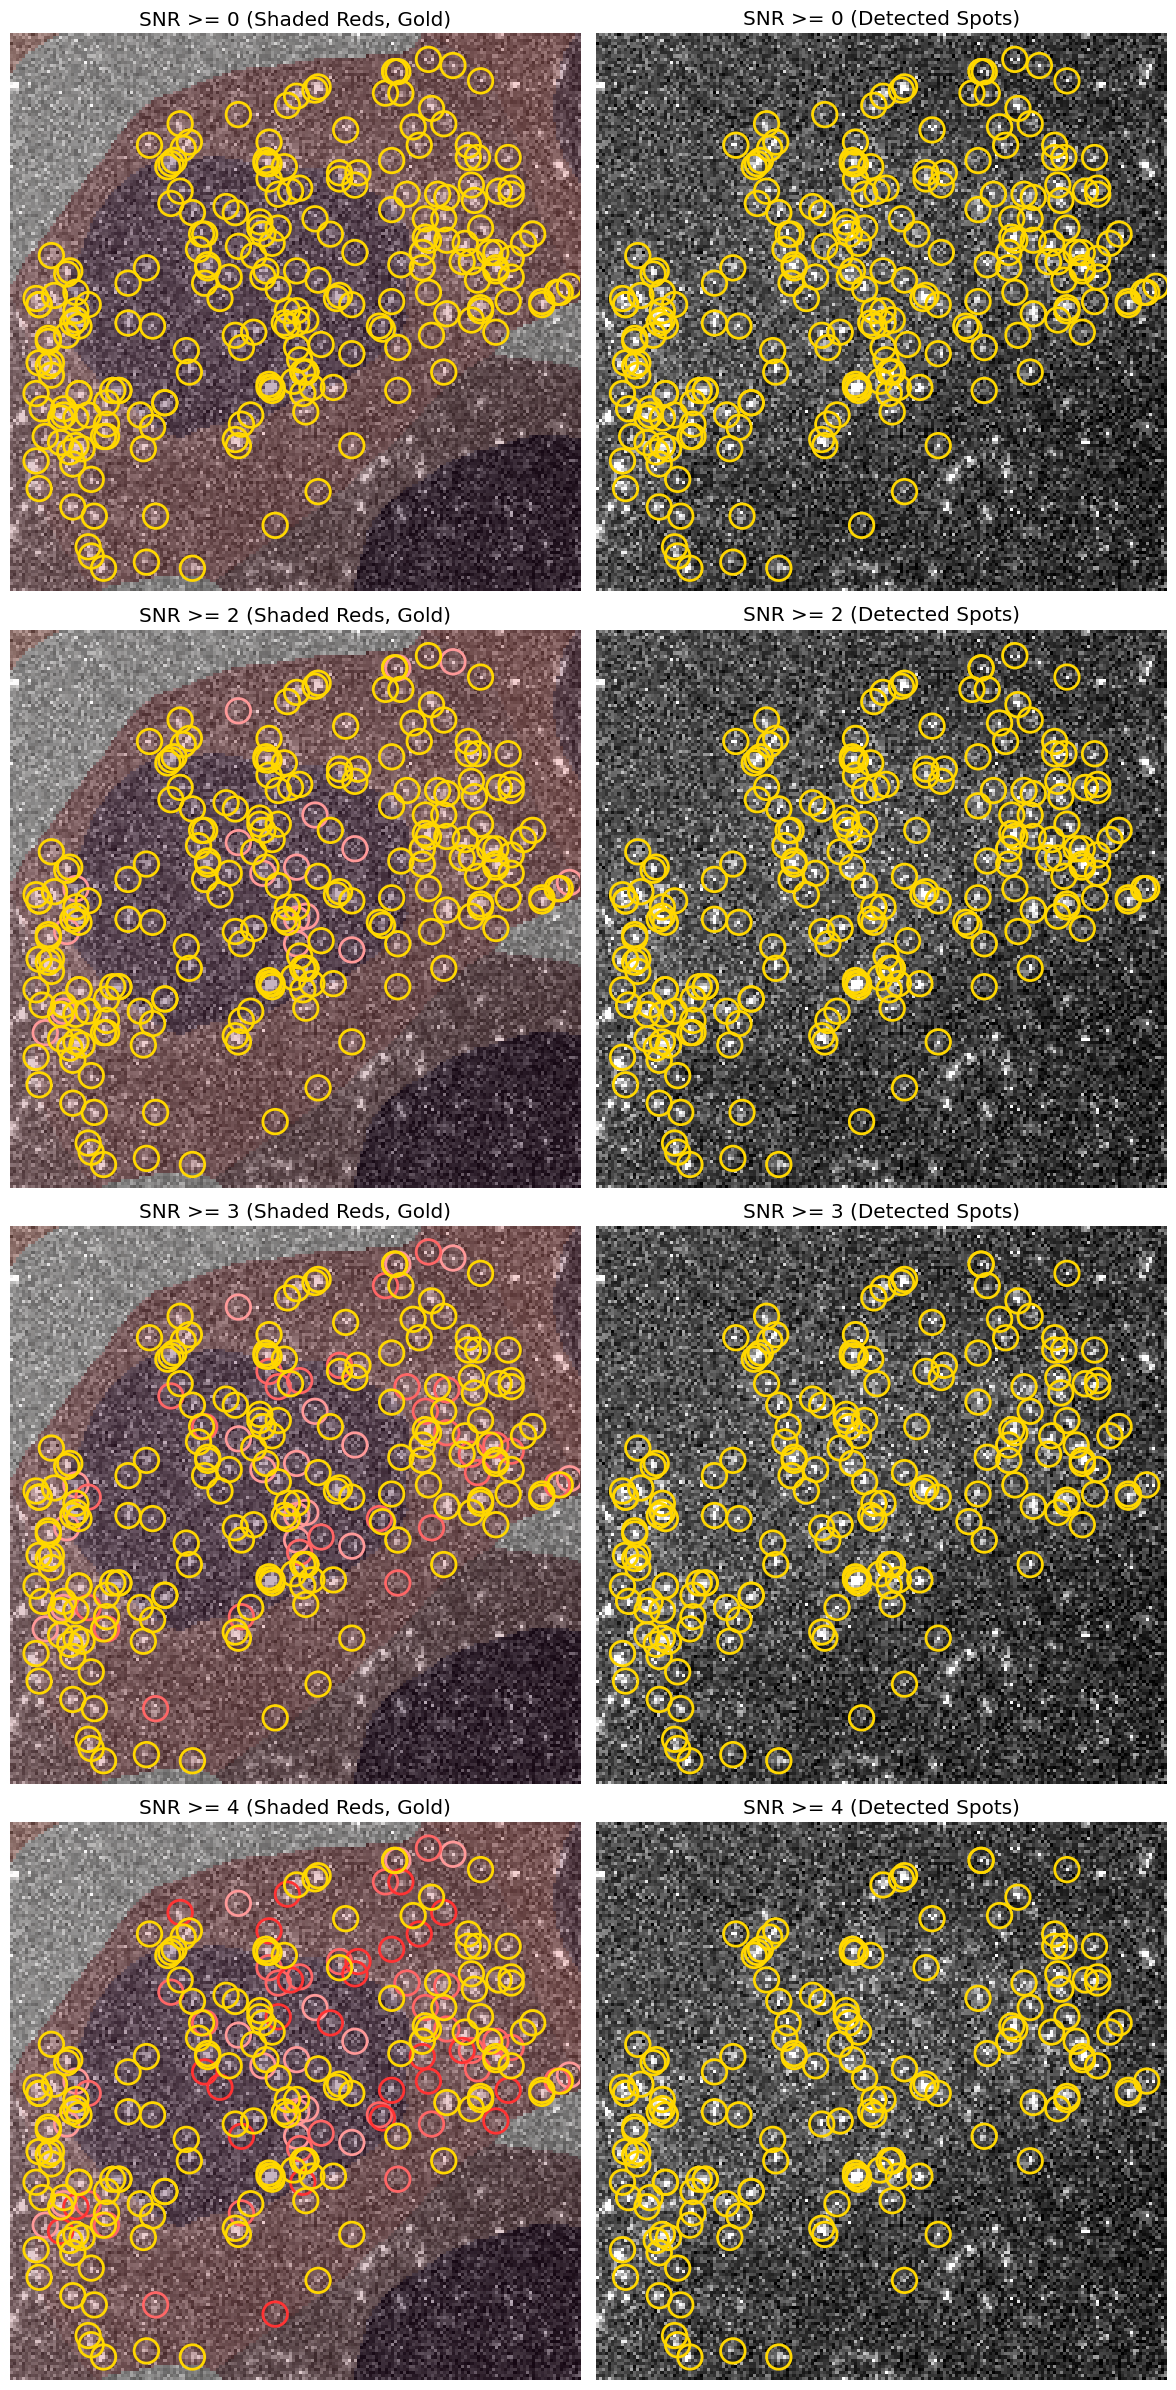

Threshold SNR >= 0: 219 kept / 219 total spots.
Threshold SNR >= 2: 202 kept / 219 total spots.
Threshold SNR >= 3: 175 kept / 219 total spots.
Threshold SNR >= 4: 149 kept / 219 total spots.


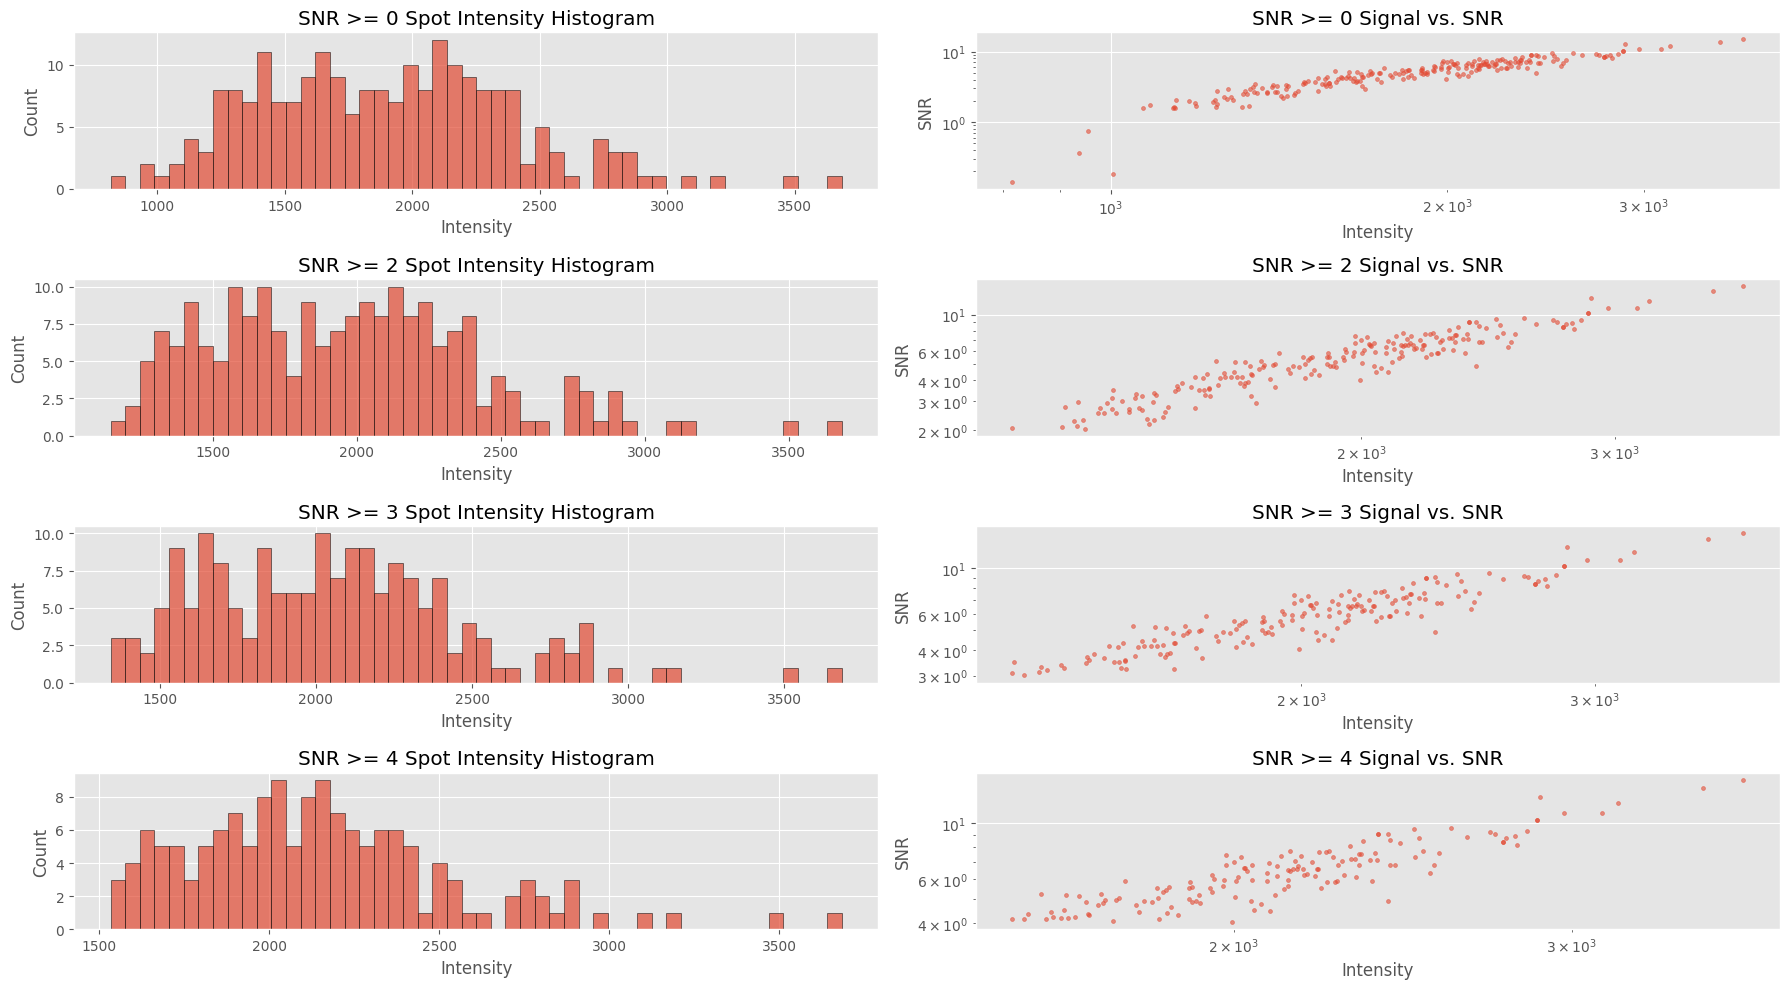

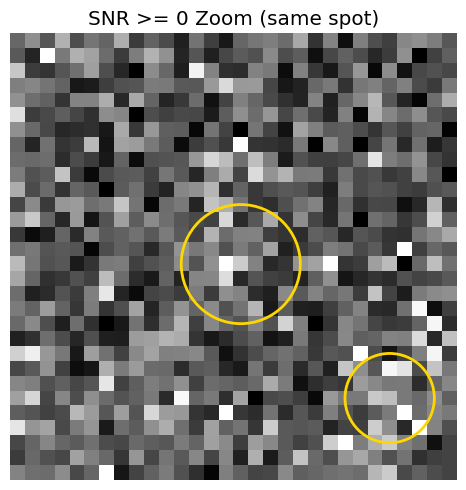

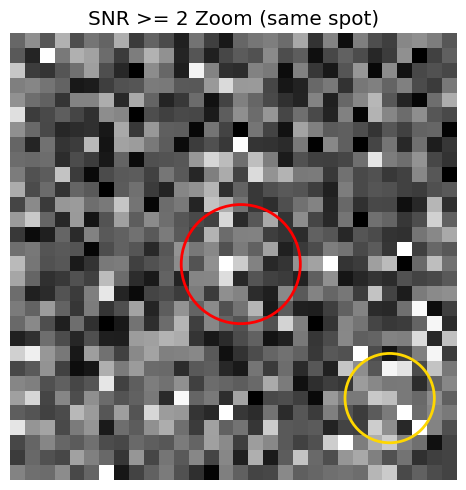

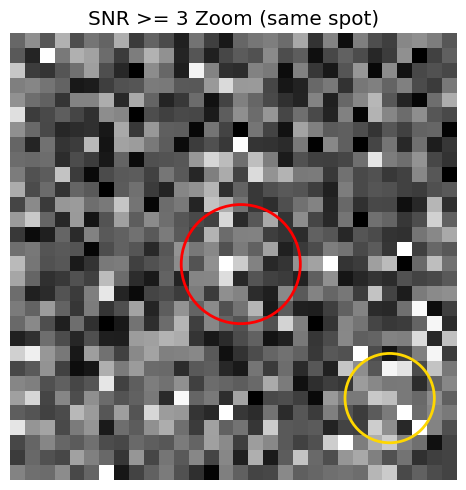

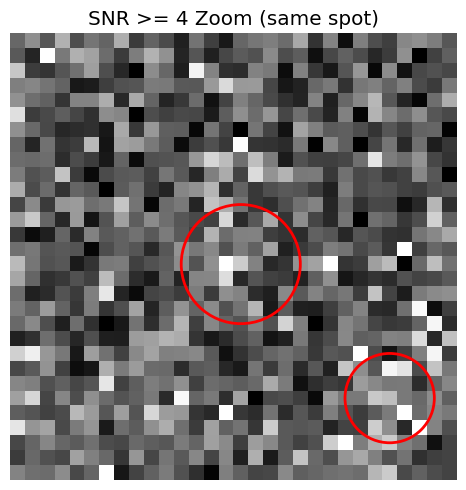

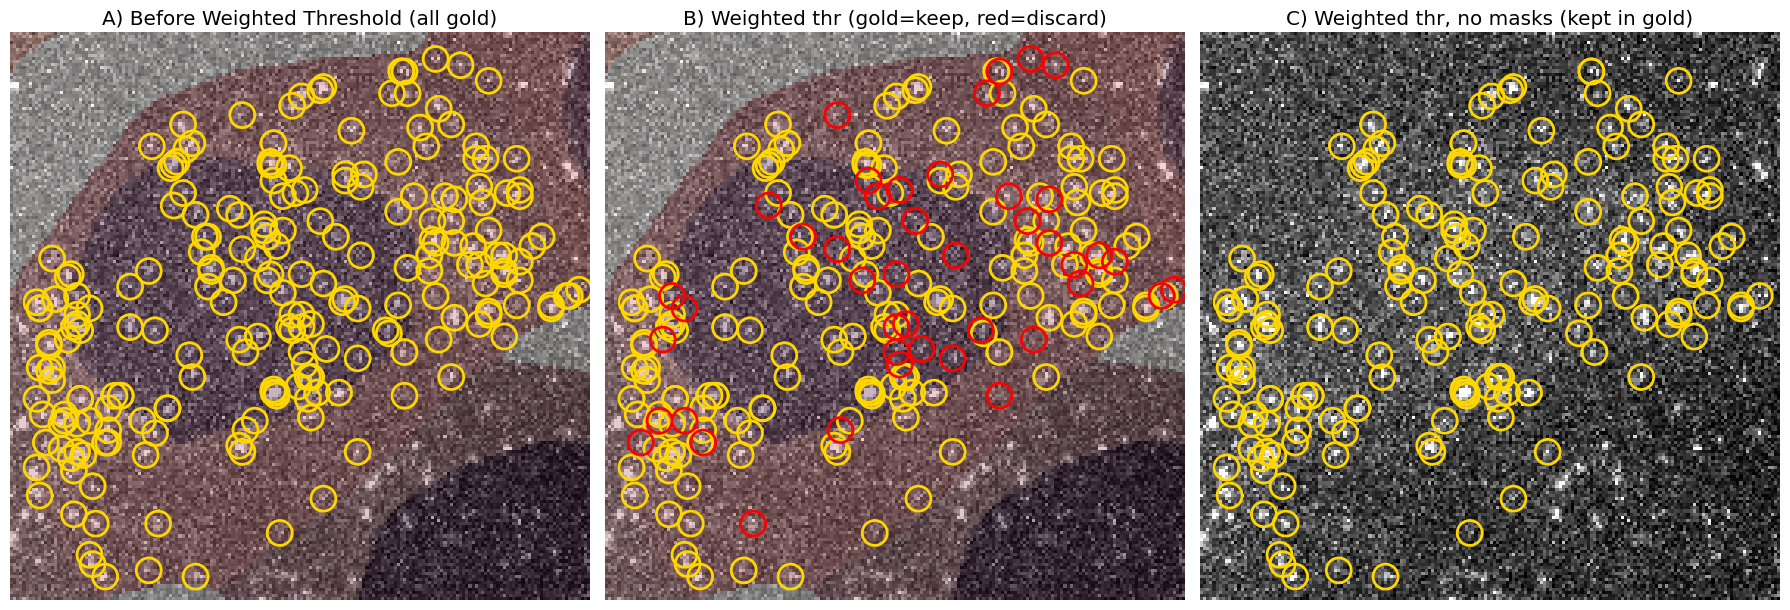

Weighted threshold => kept: 175, discarded: 44


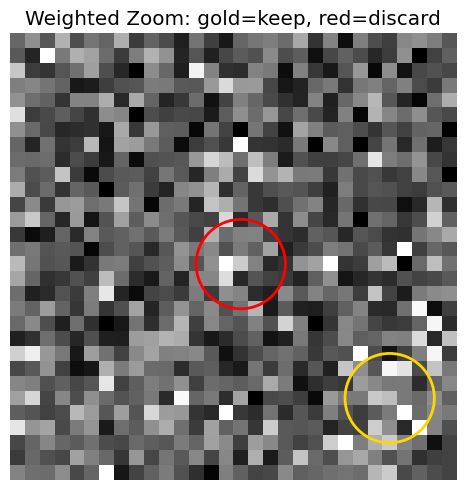

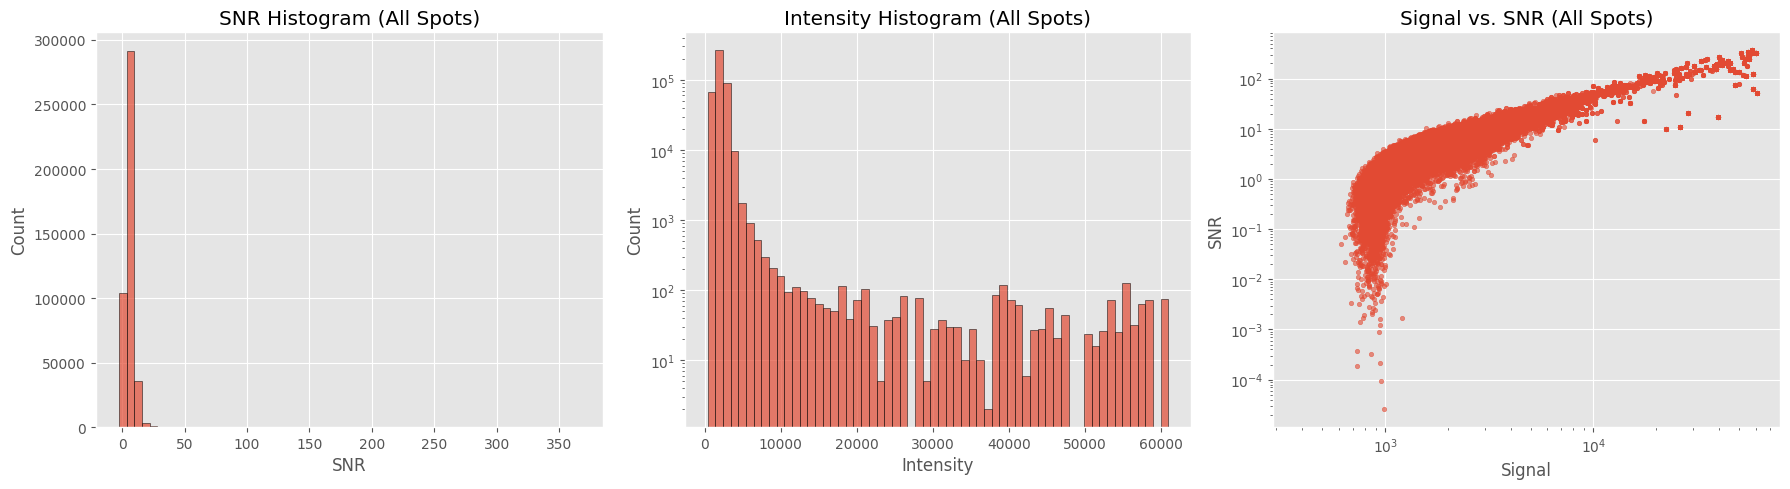

In [9]:
# run this multiple times to see a new randomly selected cell
SD.display(newFOV=True, newCell=True) # num_fovs_to_display=2,num_cells_to_display=2, num_spots_to_display=4

In [10]:
df_spots = pd.DataFrame(SD.spots)
df_spots.columns

Index(['z_px', 'y_px', 'x_px', 'cluster_index', 'is_nuc', 'cell_label',
       'nuc_label', 'snr', 'signal', 'timepoint', 'fov', 'FISH_Channel',
       'condition', 'replica', 'time', 'Dex_Conc', 'NAS_location', 'h5_idx',
       'keep_wsnr'],
      dtype='object')

In [11]:
# Number of timepoints in the dataset
print(df_spots['time'].unique())
print(df_spots['h5_idx'].unique())

[  0 150 180]
[0 1 2]


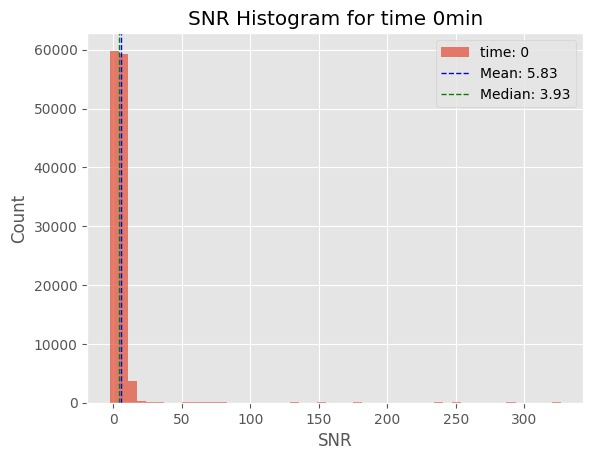

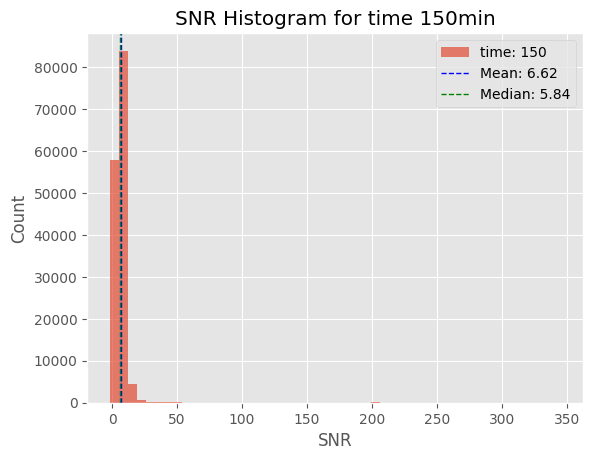

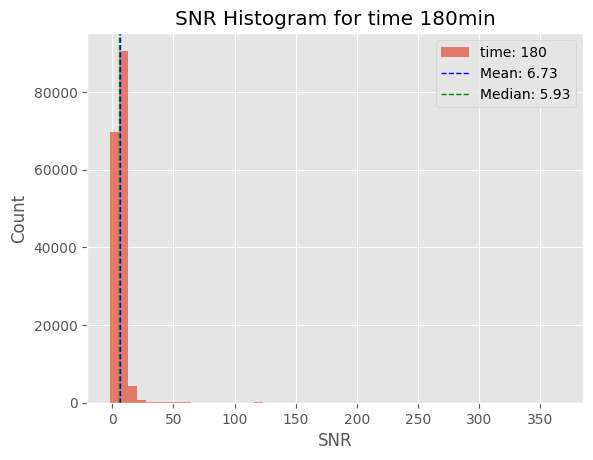

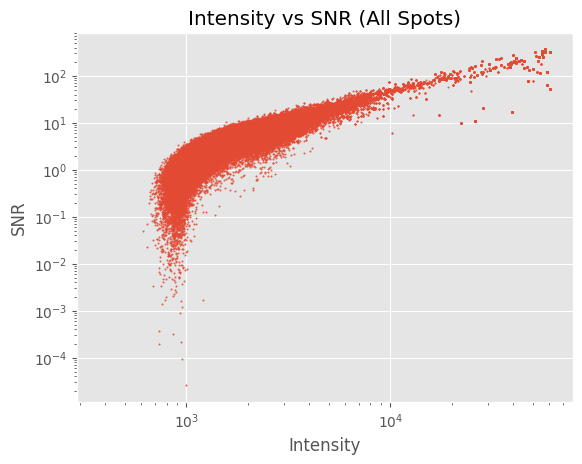

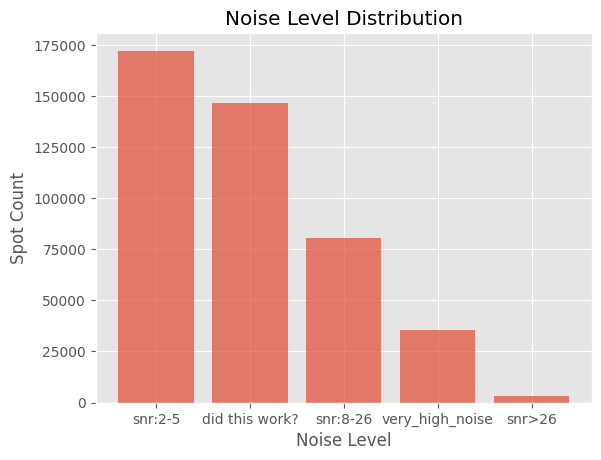

In [12]:
# Calculate statistics for all times
stats = df_spots.groupby('time')['snr'].agg(['mean', 'median', 'std'])

# Dynamic SNR thresholding based on mean ± 2*std
thresholds = {}
for time, row in stats.iterrows():
    thresholds[time] = (row['mean'] - 2 * row['std'], row['mean'] + 2 * row['std'])

# Apply dynamic thresholding
df_spots['threshold_pass'] = df_spots.apply(
    lambda row: thresholds[row['time']][0] <= row['snr'] <= thresholds[row['time']][1],
    axis=1
)

# Filtered DataFrame
df_spots_filtered = df_spots[df_spots['threshold_pass']]

# Categorize noise levels based on the paper's description
def categorize_noise(snr):
    if snr < 2:
        return 'very_high_noise'
    if 2 <= snr < 5:
        return 'snr:2-5'
    elif 8 <= snr <= 26:
        return 'snr:8-26'
    elif snr > 26:
        return 'snr>26'
    else:
        return 'did this work?'

df_spots['noise_level'] = df_spots['snr'].apply(categorize_noise)

# Plot histograms of SNR for each time
for time, group in df_spots.groupby('time'):
    mean_snr = group['snr'].mean()
    median_snr = group['snr'].median()
    std_snr = group['snr'].std()
    
    plt.hist(group['snr'], bins=50, alpha=0.7, label=f'time: {time}')
    plt.axvline(mean_snr, color='b', linestyle='dashed', linewidth=1, label=f'Mean: {mean_snr:.2f}')
    plt.axvline(median_snr, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_snr:.2f}')
    plt.title(f'SNR Histogram for time {time}min')
    plt.xlabel('SNR')
    plt.ylabel('Count')
    plt.legend()
    plt.show()


# Scatter Plot of Intensity vs SNR
plt.scatter(df_spots['signal'], df_spots['snr'], s=1, alpha=0.7)
plt.xlabel('Intensity')
plt.ylabel('SNR')
plt.title('Intensity vs SNR (All Spots)')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Noise Level Distribution
noise_level_counts = df_spots['noise_level'].value_counts()
plt.bar(noise_level_counts.index, noise_level_counts.values, alpha=0.7)
plt.title('Noise Level Distribution')
plt.xlabel('Noise Level')
plt.ylabel('Spot Count')
plt.show()


In [13]:
df_spots_filtered = df_spots[(df_spots['cell_label'] > 0)] # & (df_spots['cluster_index'] > -1)]
print(len(df_spots_filtered))

409496


In [14]:
df_clusters = pd.DataFrame(SD.clusters)
df_clusters.columns
df_clusters_filtered = df_clusters[(df_clusters['is_nuc'] > 0)]
print(len(df_clusters_filtered))

600


In [15]:
df_clusters['is_nuc'].unique()

array([0, 1])

In [16]:
SD.cellprops


nuc_label  nuc_bbox-0  nuc_bbox-1  nuc_bbox-2  nuc_bbox-3  nuc_area  \
15         16         776           0         879          66    5025.0   
16         17         872         162         936         272    4357.0   
14         15         764         330         854         478   10745.0   
9          10         504          34         615         130    7683.0   
10         11         509         487         594         608    7877.0   
..        ...         ...         ...         ...         ...       ...   
10         11         460         435         568         535    8329.0   
11         12         471         232         576         355   10548.0   
5           6         179         149         288         261    9531.0   
6           7         243         302         384         396    8379.0   
4           5         168           0         274          82    6693.0   

    nuc_centroid-0  nuc_centroid-1  nuc_intensity_max-0  nuc_intensity_max-1  \
15      832.150647       28.360597               3405.0               2490.0   
16      910.462015      226.662153               2174.0               2275.0   
14      809.769753      403.204374               2151.0               2143.0   
9       557.227906       79.584798               3367.0               2641.0   
10      551.217469      548.949473               2021.0               2011.0   
..             ...             ...                  ...                  ...   
10      511.451915      482.460199               3798.0               2537.0   
11      521.851062      297.119075               4572.0               2722.0   
5       231.142482      205.177316               3460.0               2763.0   
6       312.987111      347.622747               3802.0               2511.0   
4       218.546989       36.859555               3506.0               2843.0   

    ...  cyto_intensity_std-1  cyto_intensity_std-2  fov  timepoint  \
15  ...            290.673340             72.674614    0          0   
16  ...            256.529877             71.020790    0          0   
14  ...            257.829437             75.426086    0          0   
9   ...            377.296570             75.453064    0          0   
10  ...            262.713074             64.045120    0          0   
..  ...                   ...                   ...  ...        ...   
10  ...            250.266754             81.344086   39          0   
11  ...            356.031036             99.569969   39          0   
5   ...            336.092468            114.013214   39          0   
6   ...            317.706360             87.075493   39          0   
4   ...            324.045807             91.652527   39          0   

          condition  replica  time  Dex_Conc  \
15  DUSP1_timesweep        M     0         0   
16  DUSP1_timesweep        M     0         0   
14  DUSP1_timesweep        M     0         0   
9   DUSP1_timesweep        M     0         0   
10  DUSP1_timesweep        M     0         0   
..              ...      ...   ...       ...   
10  DUSP1_timesweep        M   180       100   
11  DUSP1_timesweep        M   180       100   
5   DUSP1_timesweep        M   180       100   
6   DUSP1_timesweep        M   180       100   
4   DUSP1_timesweep        M   180       100   

                                         NAS_location  h5_idx  
15  smFISH_images/Eric_smFISH_images/20220725/DUSP...       0  
16  smFISH_images/Eric_smFISH_images/20220725/DUSP...       0  
14  smFISH_images/Eric_smFISH_images/20220725/DUSP...       0  
9   smFISH_images/Eric_smFISH_images/20220725/DUSP...       0  
10  smFISH_images/Eric_smFISH_images/20220725/DUSP...       0  
..                                                ...     ...  
10  smFISH_images/Eric_smFISH_images/20220725/DUSP...       2  
11  smFISH_images/Eric_smFISH_images/20220725/DUSP...       2  
5   smFISH_images/Eric_smFISH_images/20220725/DUSP...       2  
6   smFISH_images/Eric_smFISH_images/20220725/DUSP...       2  
4   smFI

In [17]:
df = pd.DataFrame(SD.cellprops) 

In [18]:
df.columns

Index(['nuc_label', 'nuc_bbox-0', 'nuc_bbox-1', 'nuc_bbox-2', 'nuc_bbox-3',
       'nuc_area', 'nuc_centroid-0', 'nuc_centroid-1', 'nuc_intensity_max-0',
       'nuc_intensity_max-1', 'nuc_intensity_max-2', 'nuc_intensity_mean-0',
       'nuc_intensity_mean-1', 'nuc_intensity_mean-2', 'nuc_intensity_min-0',
       'nuc_intensity_min-1', 'nuc_intensity_min-2', 'nuc_intensity_std-0',
       'nuc_intensity_std-1', 'nuc_intensity_std-2', 'cell_label',
       'cell_bbox-0', 'cell_bbox-1', 'cell_bbox-2', 'cell_bbox-3', 'cell_area',
       'cell_centroid-0', 'cell_centroid-1', 'cell_intensity_max-0',
       'cell_intensity_max-1', 'cell_intensity_max-2', 'cell_intensity_mean-0',
       'cell_intensity_mean-1', 'cell_intensity_mean-2',
       'cell_intensity_min-0', 'cell_intensity_min-1', 'cell_intensity_min-2',
       'cell_intensity_std-0', 'cell_intensity_std-1', 'cell_intensity_std-2',
       'touching_border', 'cyto_label', 'cyto_bbox-0', 'cyto_bbox-1',
       'cyto_bbox-2', 'cyto_bbox-3

In [19]:
df_cellspots = pd.DataFrame(SD.cellspots)
df_cellspots.columns

Index(['cell_id', 'cell_area', 'nuc_area', 'nb_rna', 'nb_rna_in_nuc',
       'nb_rna_out_nuc', 'nb_foci', 'nb_transcription_site', 'fov',
       'timepoint', 'FISH_Channel', 'condition', 'replica', 'time', 'Dex_Conc',
       'NAS_location', 'h5_idx'],
      dtype='object')

In [20]:
num_TS = df_cellspots[(df_cellspots['nb_transcription_site'] > 0)]
print(len(num_TS))

313


In [21]:
# find cells that have props but arent in the cell spots
allcells = SD.cellprops
cells_wSpots = SD.cellspots
# Find cells that are in allcells but not in cells_wSpots
merged = allcells.merge(cells_wSpots, how='left', left_on=['nuc_label', 'fov', 'NAS_location'], right_on=['cell_id', 'fov', 'NAS_location'], indicator=True)
print(merged.shape)
same_entries = merged[merged['_merge'] == 'both'].drop(columns=['cell_id', '_merge'])
different_entries = merged[merged['_merge'] == 'left_only'].drop(columns=['cell_id', '_merge'])

print("Same entries:")
print(same_entries.shape)
print("\nDifferent entries:")
print(different_entries.shape)

(2046, 85)
Same entries:
(1170, 83)

Different entries:
(876, 83)


There are 2046 cells in this data set
There are 1170 cells with spots
496 cells are touching the border and are not counted


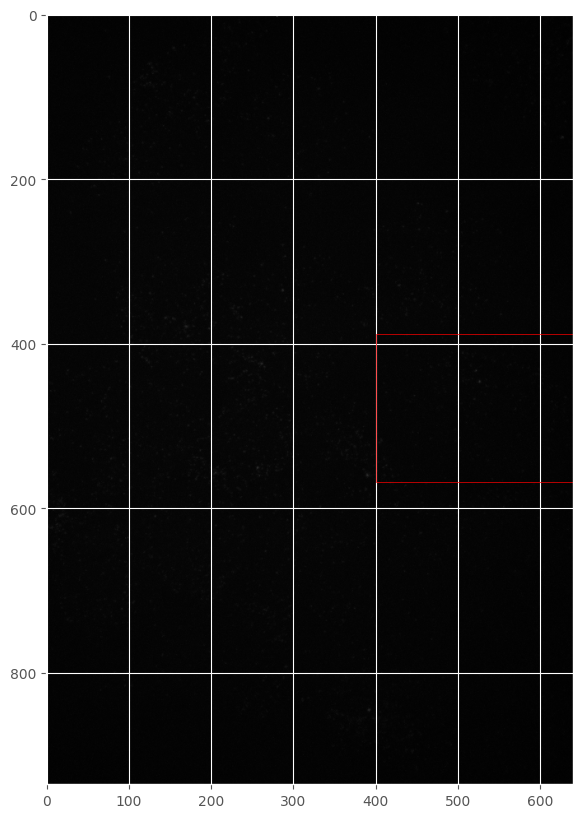

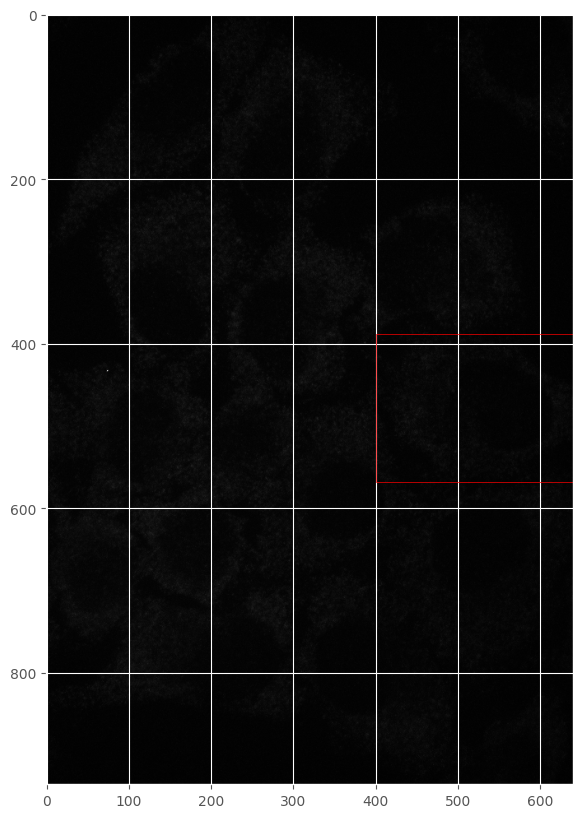

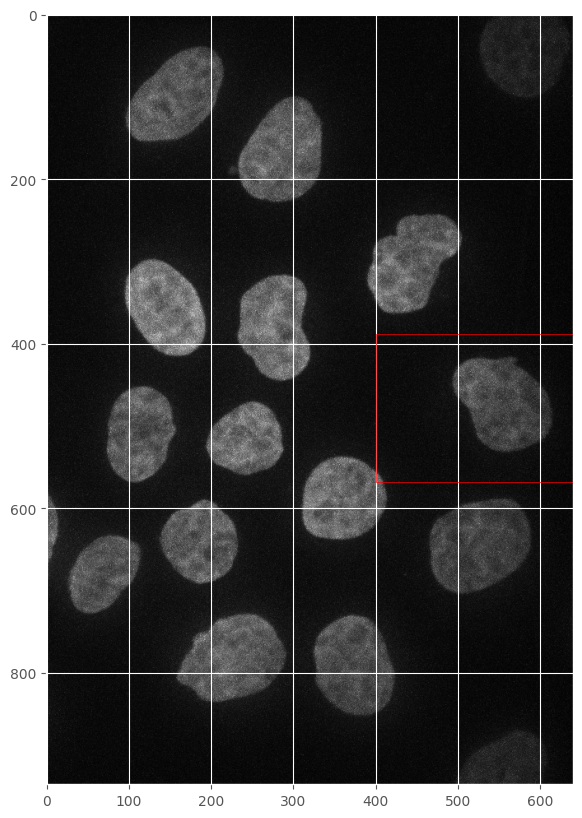

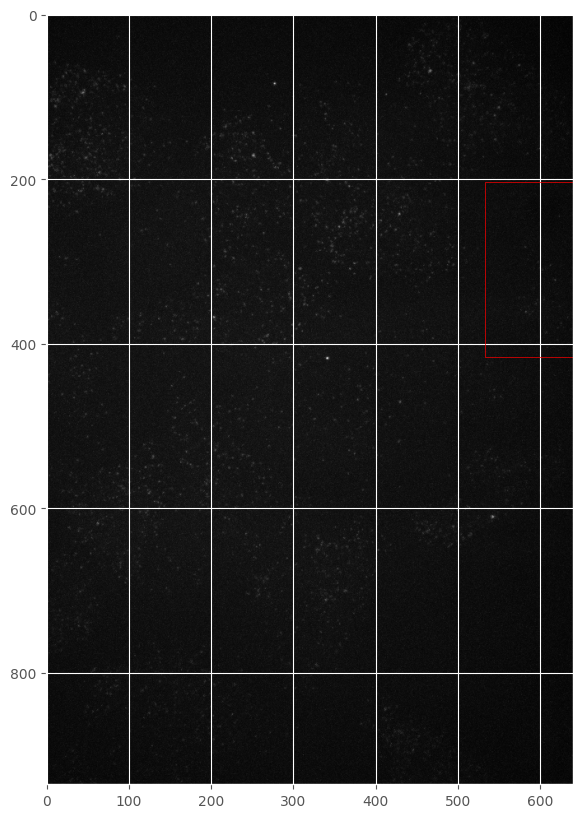

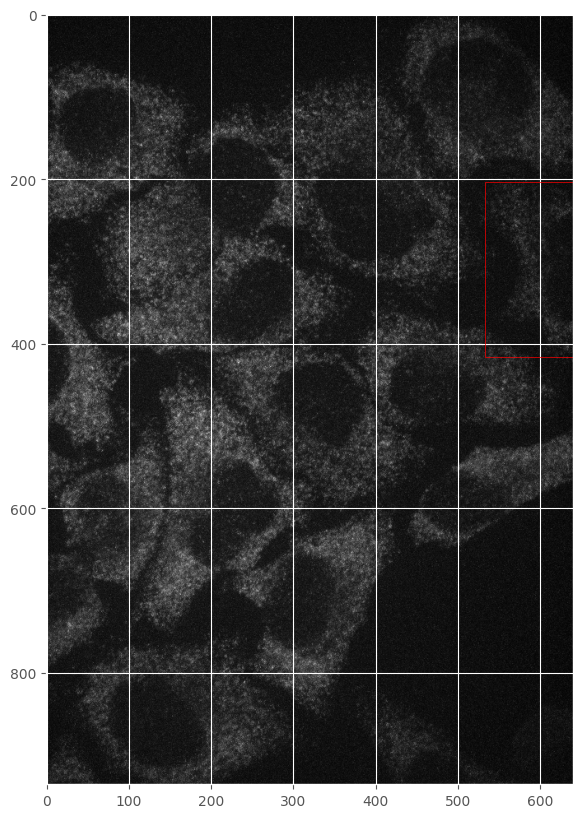

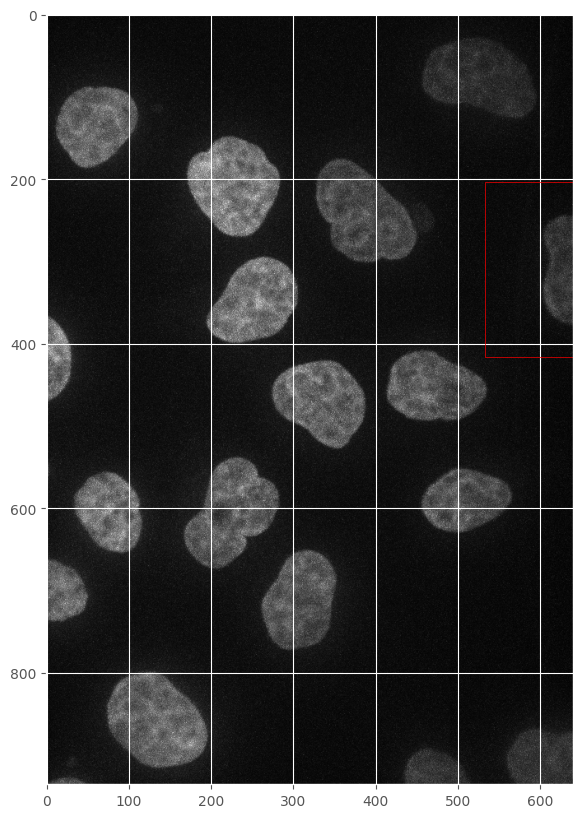

In [22]:
import random
import dask.array as da
print(f'There are {allcells.shape[0]} cells in this data set')
print(f'There are {cells_wSpots.shape[0]} cells with spots')

# how many are have bounded boxes touching the border
print(f'{different_entries['touching_border'].sum()} cells are touching the border and are not counted')

# Select a random row from the different_entries dataframe
for _ in range(2):
    random_row = different_entries[~different_entries['touching_border']].sample(n=1).iloc[0]

    # Read the h5 file
    h5_file = random_row['NAS_location']
    h5_file = os.path.join(r'\\munsky-nas.engr.colostate.edu\share', h5_file) # TODO this will need to be updated so you dont have to find it to get it to work
    with h5py.File(h5_file, 'r') as f:
        # Grab the mask and raw_image
        masks = da.from_array(f['/masks'])
        raw_images = da.from_array(f['/raw_images'])

        # Extract the bounding box coordinates
        bbox = [random_row['cell_bbox-0'], random_row['cell_bbox-1'], random_row['cell_bbox-2'], random_row['cell_bbox-3']]

        img = raw_images[random_row['fov'], random_row['timepoint_x']].squeeze()
        for c in range(img.shape[0]):
            # Display the raw image with the selected cell highlighted
            t = np.max(img[c, :, :,:], axis=0)
            t.compute()
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.imshow(t, cmap='gray')
            rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0], edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.show()

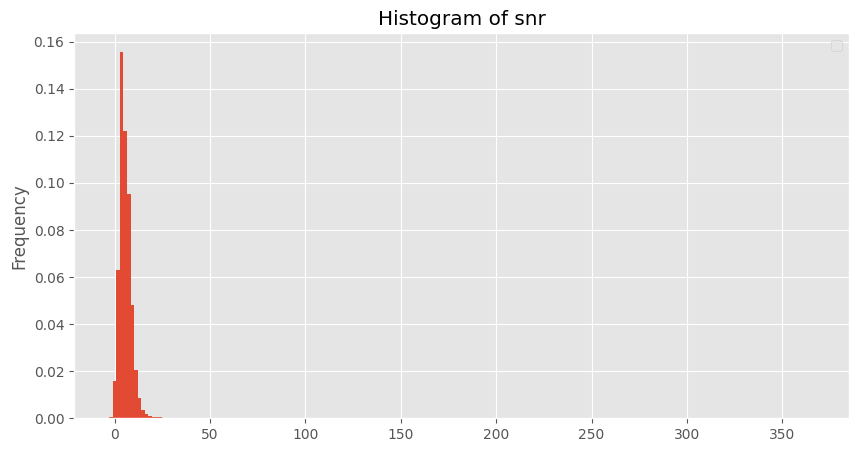

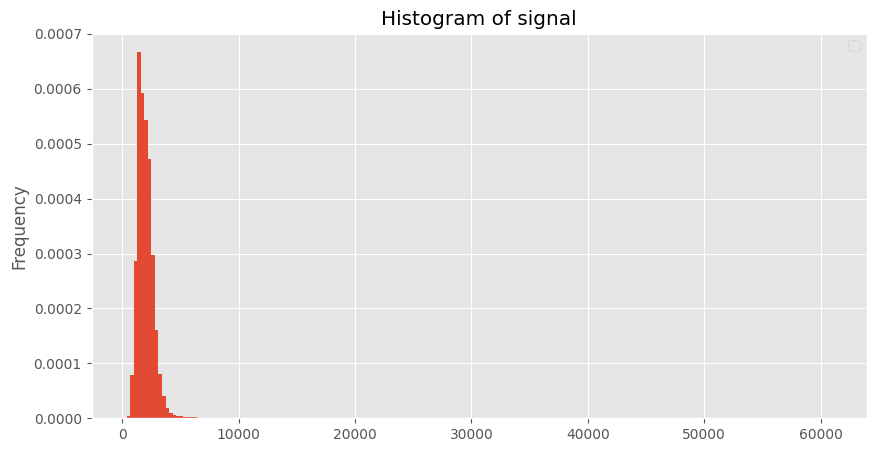

In [23]:
# Histogram of spots
keys_to_plot = ['signal', 'snr']
for k in SD.spots.keys():
    if k in keys_to_plot:
        # Plot histogram for 'area'
        plt.figure(figsize=(10, 5))
        plt.hist(SD.spots[k], bins=200, density=True)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {k}')
        plt.legend()
        plt.show()

In [24]:
SD.cellspots.keys()

Index(['cell_id', 'cell_area', 'nuc_area', 'nb_rna', 'nb_rna_in_nuc',
       'nb_rna_out_nuc', 'nb_foci', 'nb_transcription_site', 'fov',
       'timepoint', 'FISH_Channel', 'condition', 'replica', 'time', 'Dex_Conc',
       'NAS_location', 'h5_idx'],
      dtype='object')

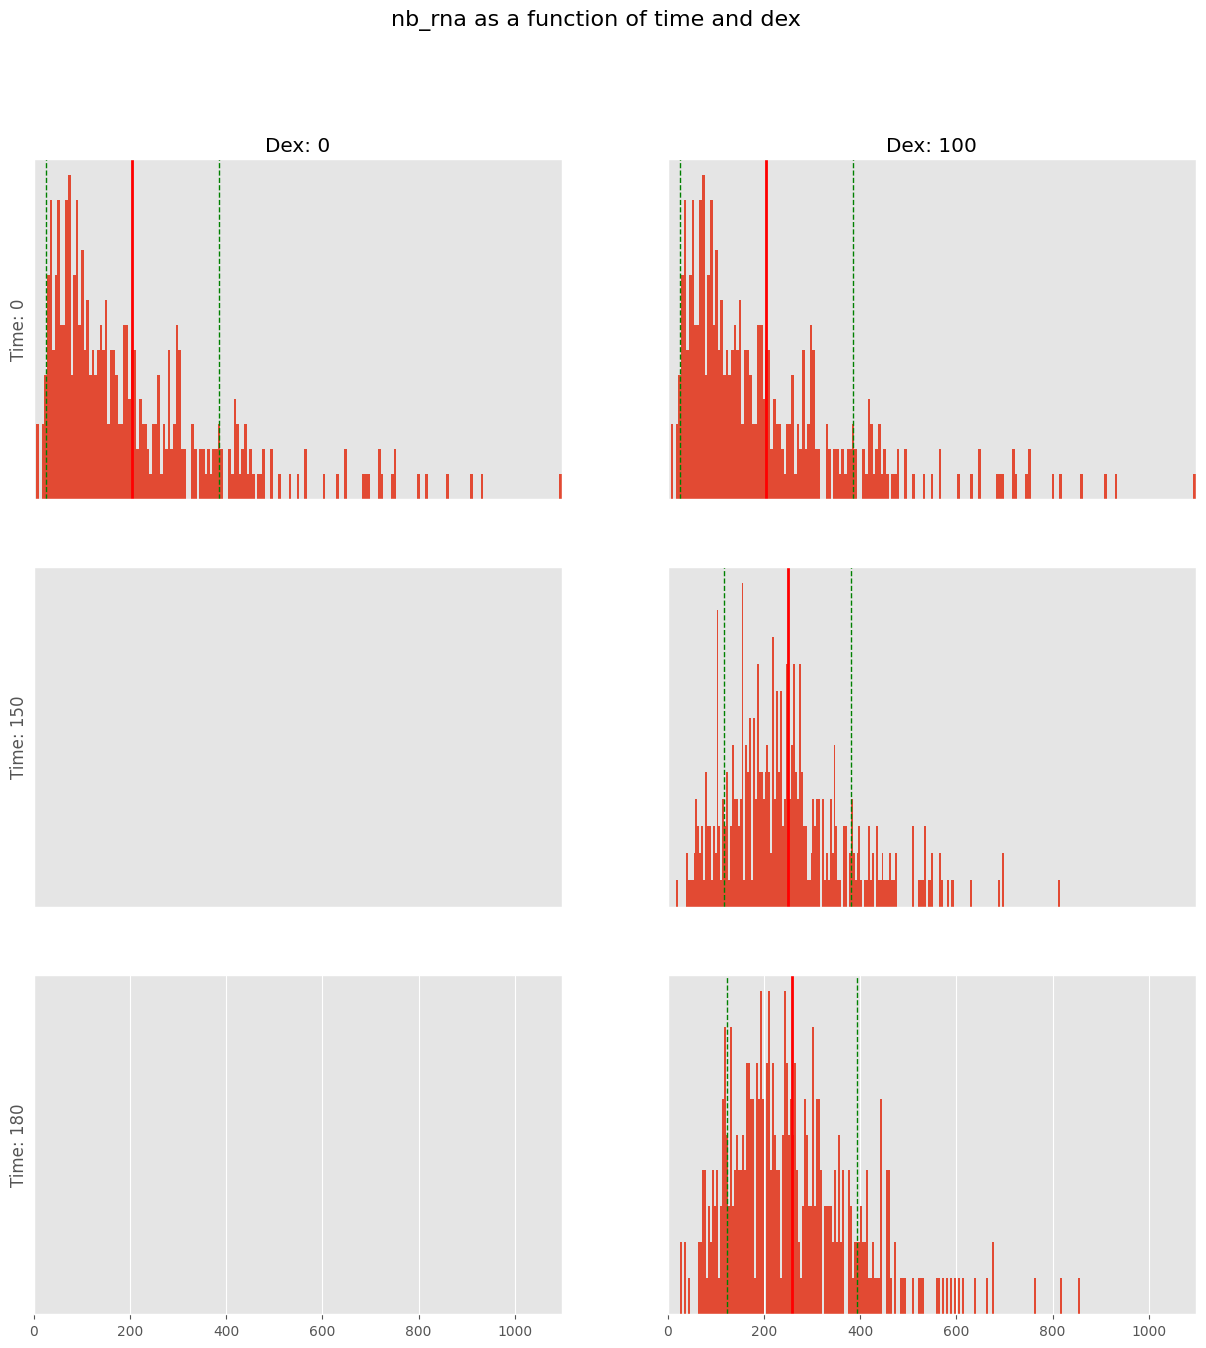

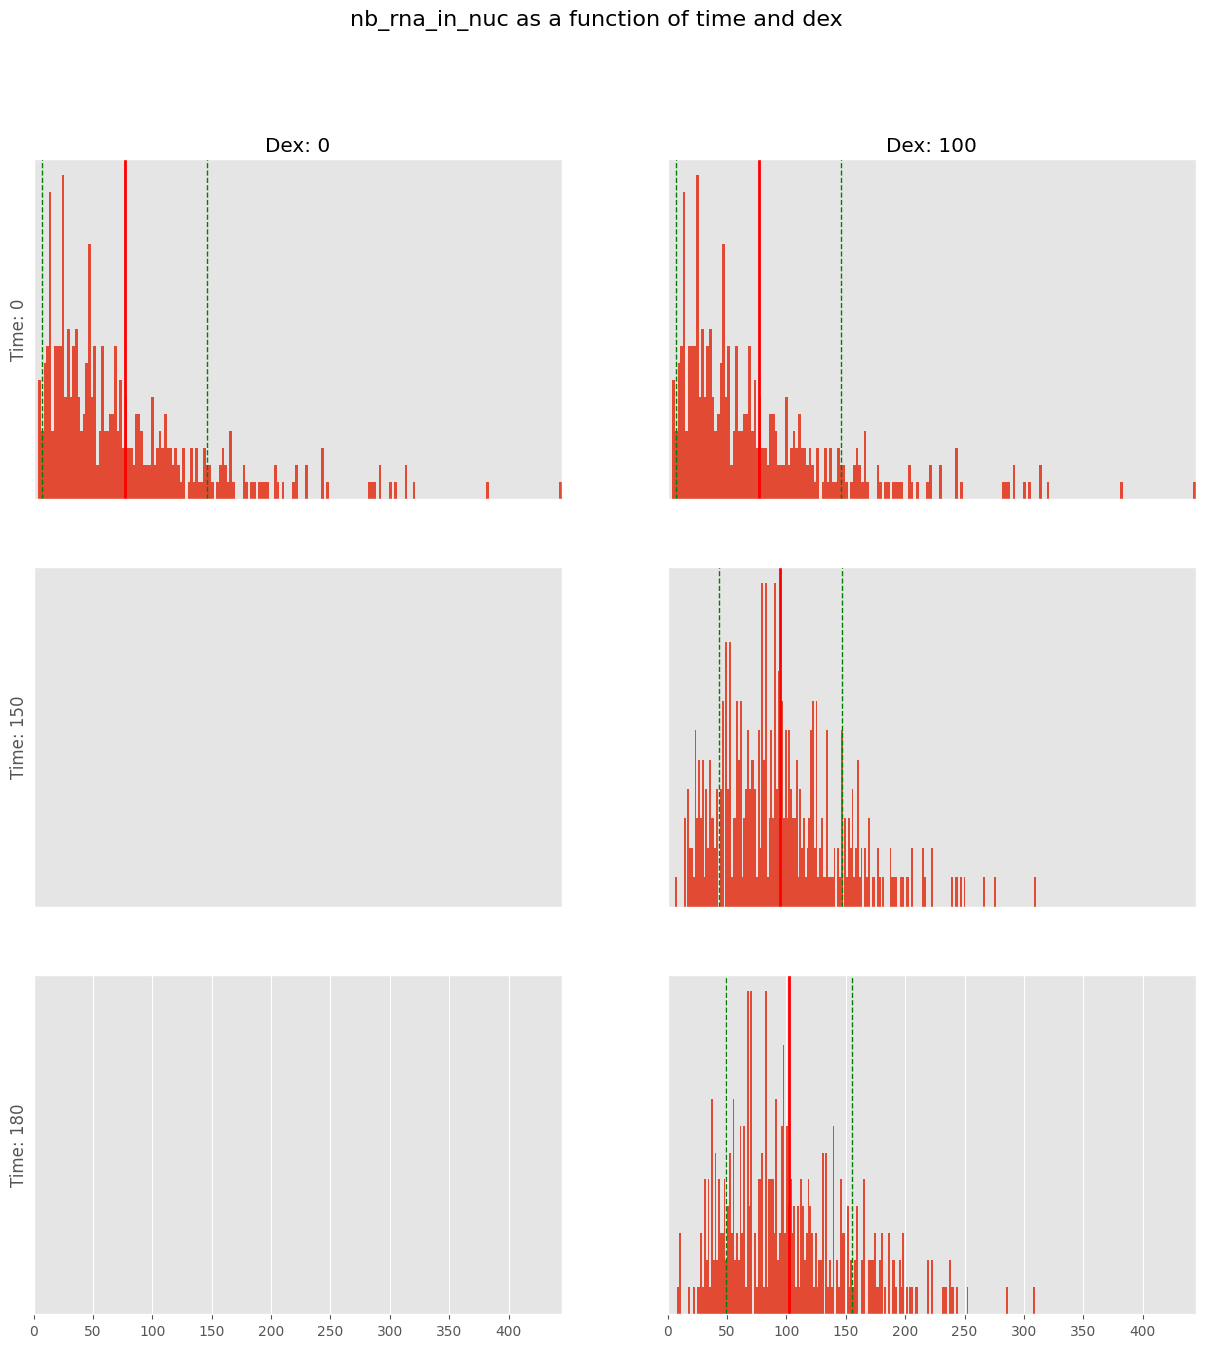

In [25]:
# spot counts as a function of time and dex
keys_to_plot = ['nb_rna', 'nb_rna_in_nuc']


tp_set = sorted(set(SD.cellspots['time']))
dex_set = sorted(set(SD.cellspots['Dex_Conc']))
for k in keys_to_plot:
    fig, axs = plt.subplots(len(tp_set), len(dex_set), figsize=(15, 15))
    fig.suptitle(f'{k} as a function of time and dex', fontsize=16)
    for i_d, d in enumerate(dex_set):
        data = SD.cellspots[SD.cellspots['Dex_Conc'] == d]
        for i_t, t in enumerate(tp_set):
            temp = data[data['time'] == t]
            mean_val = temp[k].mean()
            std_val = temp[k].std()
            if d == 0 and t == 0:
                for ax in axs[i_t, :]:
                    ax.hist(temp[k], bins=200, density=True)
                    ax.axvline(mean_val, color='r', linestyle='solid', linewidth=2)
                    ax.axvline(mean_val + std_val, color='g', linestyle='dashed', linewidth=1)
                    ax.axvline(mean_val - std_val, color='g', linestyle='dashed', linewidth=1)
                    ax.set_xlim([0, SD.cellspots[k].max()])
                    ax.grid(True)  # Turn on grid lines
                    if i_t != len(tp_set) - 1:
                        axs[i_t, i_d].set_xticks([])
                    ax.set_yticks([])
                axs[i_t, 0].set_ylabel(f'Time: {t}')
            else:
                axs[i_t, i_d].hist(temp[k], bins=200, density=True)
                axs[i_t, i_d].axvline(mean_val, color='r', linestyle='solid', linewidth=2)
                axs[i_t, i_d].axvline(mean_val + std_val, color='g', linestyle='dashed', linewidth=1)
                axs[i_t, i_d].axvline(mean_val - std_val, color='g', linestyle='dashed', linewidth=1)
                axs[i_t, i_d].set_xlim([0, SD.cellspots[k].max()])
                axs[i_t, i_d].grid(True)  # Turn on grid lines
                if i_t != len(tp_set) - 1:
                    axs[i_t, i_d].set_xticks([])
                axs[i_t, i_d].set_yticks([])
                axs[i_t, 0].set_ylabel(f'Time: {t}')
                axs[0, i_d].set_title(f'Dex: {d}')
    plt.show()



# BIGFISH Visualization

In [26]:
import bigfish
import bigfish.stack as stack
import bigfish.multistack as multistack
import bigfish.plot as plot

## Weighted Approach

In this approach, every spot is retained but given a weight reflecting its estimated reliability. Higher weights indicate higher trust in that spot.

### Example Weight Scheme
Based on the paper’s reported errors:

- **SNR < 2**: Discard (weight = 0.0)
- **2 ≤ SNR < 5**: High noise, ~24% error ⇒ reliability ~ 76% ⇒ weight = 0.76
- **5 ≤ SNR < 8**: Not explicitly given, but presumably better than 24% error ⇒ weight = 0.85
- **8 ≤ SNR ≤ 26**: Medium/low noise, ~1.4–5.5% error ⇒ reliability ~ 94–98.6% ⇒ weight = 0.95
- **SNR > 26**: Very low noise, ~1.4% (or lower) error ⇒ ~98.6% reliability ⇒ weight = 0.99

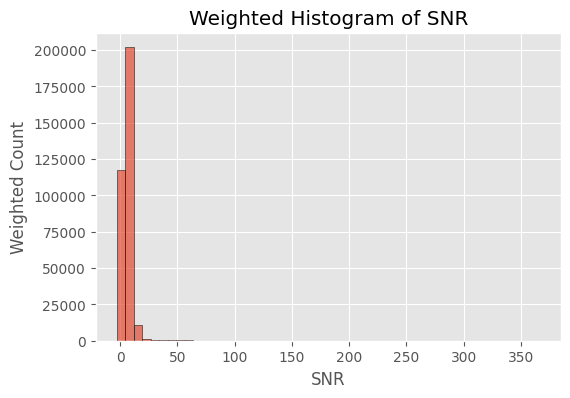

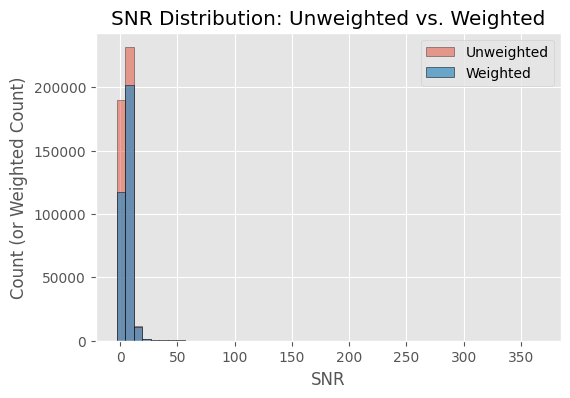

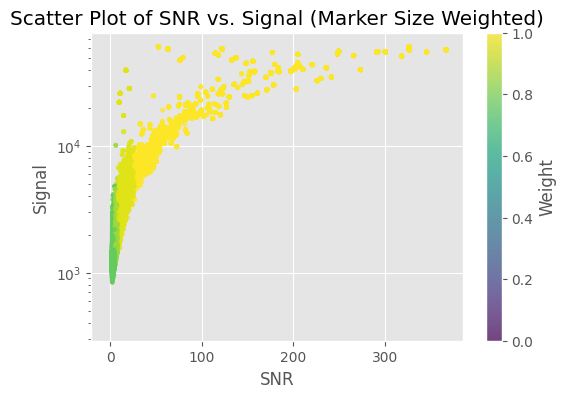

weighted Count by SNR Bin:
          count
snr_bin        
<2        32736
2–5      172236
5–8      146357
8–26      80555
>26        3447


In [27]:
# Weighted snr analysis

# 1. Assign Weights Based on SNR Ranges
def assign_weight(snr):
    """Return a weight based on known or estimated detection reliability."""
    if snr < 2:
        # Very noisy => discard
        return 0.0
    elif 2 <= snr < 5:
        # High noise => ~24% error => ~76% reliable
        return 0.76
    elif 5 <= snr < 8:
        # Intermediate between high & medium => guess ~85% reliability
        return 0.85
    elif 8 <= snr <= 26:
        # Medium/low noise => 1.4–5.5% error => pick ~95% reliability
        return 0.95
    else:  # snr > 26
        return 1

df_spots['weight'] = df_spots['snr'].apply(assign_weight)

# 2. Weighted Histogram of SNR
plt.figure(figsize=(6, 4))
plt.hist(
    df_spots['snr'], 
    bins=50, 
    weights=df_spots['weight'], 
    alpha=0.7,
    edgecolor='black'
)
plt.title('Weighted Histogram of SNR')
plt.xlabel('SNR')
plt.ylabel('Weighted Count')
plt.show()

# 3. Compare Weighted vs. Unweighted Histograms
plt.figure(figsize=(6, 4))

# Unweighted
plt.hist(
    df_spots['snr'], 
    bins=50, 
    alpha=0.5, 
    label='Unweighted', 
    edgecolor='black'
)

# Weighted
plt.hist(
    df_spots['snr'], 
    bins=50, 
    weights=df_spots['weight'], 
    alpha=0.7, 
    label='Weighted', 
    edgecolor='black'
)
plt.title('SNR Distribution: Unweighted vs. Weighted')
plt.xlabel('SNR')
plt.ylabel('Count (or Weighted Count)')
plt.legend()
plt.show()

# 4. Weighted Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(
    df_spots['snr'], 
    df_spots['signal'], 
    s=10 * df_spots['weight'],  # scale dot size by weight
    c=df_spots['weight'],       # color also by weight (optional)
    cmap='viridis', 
    alpha=0.7
)
plt.title('Scatter Plot of SNR vs. Signal (Marker Size Weighted)')
plt.xlabel('SNR')
plt.ylabel('Signal')
plt.colorbar(label='Weight')
plt.yscale('log')  # if you want log scale for signal
plt.show()

# 5. Basic Statistics Showing Mean Weight per SNR Range
bins = [0, 2, 5, 8, 26, np.inf]
labels = ['<2', '2–5', '5–8', '8–26', '>26']
df_spots['snr_bin'] = pd.cut(df_spots['snr'], bins=bins, labels=labels)

stats_weight = df_spots.groupby('snr_bin')['weight'].agg(['count'])
print("weighted Count by SNR Bin:")
print(stats_weight)


## Probabilistic Approach

Here, instead of giving each spot a continuous weight, we use a Bernoulli process to decide per spot whether it’s kept or discarded, based on an estimated probability of being a true positive (TP).

### Estimate Probability of True Positive \(P(TP|SNR)\)
Sample from a Bernoulli distribution:

### Example Probability Scheme
Using the same error logic:

- **SNR < 2**: \(P(TP) = 0\) (discard)
- **2 ≤ SNR < 5**: error \(\approx 24\%\) ⇒ \(P(TP) = 0.76\)
- **5 ≤ SNR < 8**: intermediate guess \(P(TP) = 0.85\)
- **8 ≤ SNR ≤ 26**: error \(\approx 1.4\% - 5.5\%\) ⇒ \(P(TP) = 0.95\)
- **SNR > 26**: error \(\approx 1.4\%\) ⇒ \(P(TP) \approx 0.986\)


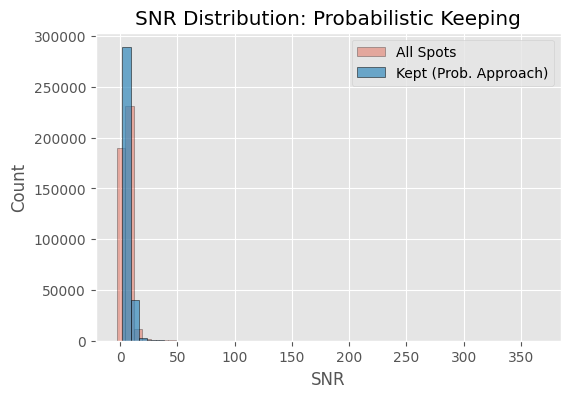

Kept Spots: 335364, Discarded Spots: 102899
Kept fractions over multiple runs: [np.float64(0.7644930099050113), np.float64(0.7650702888448261), np.float64(0.765617905230421), np.float64(0.7645865610375505), np.float64(0.7656133417605411)]


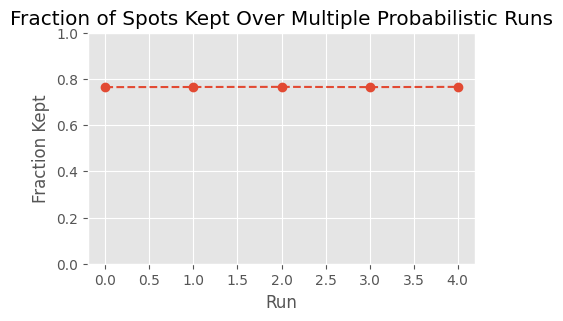

In [28]:
# 1. Define Probability of True Positive
def prob_true_positive(snr):
    """Return P(TP) based on known or estimated detection error."""
    if snr < 2:
        return 0.0
    elif 2 <= snr < 5:
        return 0.76
    elif 5 <= snr < 8:
        return 0.85
    elif 8 <= snr <= 26:
        return 0.95
    else:  # snr > 26
        return 0.986

df_spots['pTP'] = df_spots['snr'].apply(prob_true_positive)

# 2. Single Realization (One Draw per Spot)
np.random.seed(42)  # For reproducibility
df_spots['keep_prob_approach'] = np.random.rand(len(df_spots)) < df_spots['pTP']

# 3. Visualize Kept vs. Discarded
df_kept = df_spots[df_spots['keep_prob_approach'] == True]
df_disc = df_spots[df_spots['keep_prob_approach'] == False]

plt.figure(figsize=(6, 4))
plt.hist(
    df_spots['snr'], 
    bins=50, 
    alpha=0.4, 
    label='All Spots', 
    edgecolor='black'
)
plt.hist(
    df_kept['snr'], 
    bins=50, 
    alpha=0.7, 
    label='Kept (Prob. Approach)', 
    edgecolor='black'
)
plt.title('SNR Distribution: Probabilistic Keeping')
plt.xlabel('SNR')
plt.ylabel('Count')
plt.legend()
plt.show()

# 4. Compare Number of Spots Kept vs. Discarded
kept_count = len(df_kept)
discarded_count = len(df_disc)
print(f"Kept Spots: {kept_count}, Discarded Spots: {discarded_count}")

# 5. (Optional) Multiple Realizations
# If you want to see how stable the approach is over multiple runs
n_runs = 5
kept_fractions = []
for i in range(n_runs):
    # Draw Bernoulli for each spot
    keep_vec = np.random.rand(len(df_spots)) < df_spots['pTP']
    # Fraction of spots kept
    kept_fraction = keep_vec.mean()
    kept_fractions.append(kept_fraction)

print("Kept fractions over multiple runs:", kept_fractions)
plt.figure(figsize=(5, 3))
plt.plot(range(n_runs), kept_fractions, marker='o', linestyle='--')
plt.ylim(0, 1)
plt.title('Fraction of Spots Kept Over Multiple Probabilistic Runs')
plt.xlabel('Run')
plt.ylabel('Fraction Kept')
plt.show()

In [29]:
am.close()